In [175]:
# Import packages
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [176]:
# Load donations.json

filename = "data/kevin_samuel_donations.json"

with open(filename) as json_file: 
    donations = json.load(json_file)

# La thunasse ramassée au total

In [177]:
L = []
for videoid,videoobj in donations.items():
    amount = videoobj["resume"]["donations_total"]
    date = videoobj["resume"]["start_unix"]
    duration = videoobj["resume"]["duration_seconds"]
    L.append((date,amount,duration))
    
L.sort(key = lambda a : a[0])
thunasse_total = sum([item[1] for item in L])

print("la thunasse total ramassée sur", str(len(donations)), "vidéos est de : ", str(round(thunasse_total)), " €")

la thunasse total ramassée sur 215 vidéos est de :  93906  €


# Taux horaire

In [178]:
total_duration = sum([item[2] for item in L])
winrate = (3600*thunasse_total) / total_duration

print("Taux horaire : ",str(round(winrate,2)),"€ / h")

Taux horaire :  263.83 € / h


# La thunasse cumulée ramassée dans le temps

In [179]:
x = []
y = []
for item in L:
    x.append(item[0])
    y.append(item[1])
x = np.array(x)
y = np.array(y)

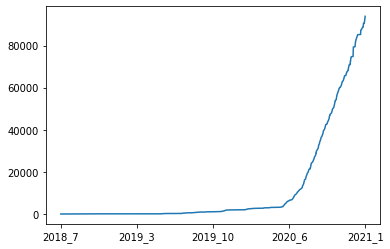

In [180]:
nthicks = 5
x_thicks = np.linspace(x[0],x[-1],nthicks)
x_thicks_labels = pd.to_datetime(x_thicks,unit="s")
x_thicks_labels = [str(item.year)+"_"+str(item.month) for item in x_thicks_labels]

plt.plot(x, np.cumsum(y))
plt.xticks(x_thicks, x_thicks_labels, rotation='horizontal')
plt.show()

### **Sympa le bump en mai 2020!**

# Evolution de la thunasse les 18 derniers mois

In [181]:
index = pd.to_datetime(x,unit="s")
series = pd.Series(y, index = index)
series.resample('M').sum().tail(18)

2019-08-31      296.691368
2019-09-30      307.558178
2019-10-31       17.360202
2019-11-30      787.874095
2019-12-31      169.026777
2020-01-31      400.777744
2020-02-29      278.232259
2020-03-31      241.975627
2020-04-30      205.556081
2020-05-31     3056.877734
2020-06-30     4697.580915
2020-07-31     9847.069061
2020-08-31    12569.280855
2020-09-30    13211.688676
2020-10-31    13561.200234
2020-11-30    10948.512995
2020-12-31    14251.775777
2021-01-31     8625.348399
Freq: M, dtype: float64

# Les donateurs

In [182]:
members = {}
for videoid, videoobj in donations.items():
    for msg in videoobj["messages"]:
        if "amount_euros" in msg:
            author = msg["author"]
            amount= msg["amount_euros"]
            members[author] = members.get(author,0) + amount
members = [(k,v) for k,v in members.items()]
members.sort(key=lambda a : -a[1])

In [183]:
print(len(members),"personnes ont fait au moins un don sur la chaîne")

2960 personnes ont fait au moins un don sur la chaîne


# Les biggest donateurs

In [184]:
topk = 10
print("les plus",str(topk),"gros donateurs sont : ")
print("")
for m,v in members[:topk]:
    print(m,":",str(round(v)),"€")

les plus 10 gros donateurs sont : 

Ike Ogiamien : 11979 €
theo ansa : 3905 €
Nate Tyler : 1639 €
CG Cap : 1244 €
Jay Kanella : 1133 €
Profits Over Wages : 1116 €
Good Men : 1048 €
Cordarryl Nelson : 961 €
David Johnson : 880 €
Antoine Wade : 828 €


# Distribution des donateurs

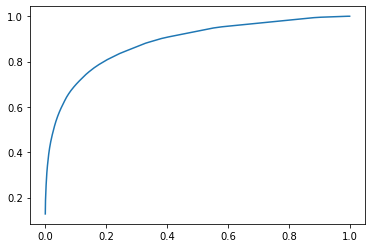

In [191]:
total_part = np.cumsum([item[1] for item in members]) / np.sum([item[1] for item in members])
members_part = np.array([i/len(total_part) for i in range(len(total_part))])
ndonateurs = np.argmin(np.abs(total_part - 0.5))
fifty_resp = round(members_part[np.argmin(np.abs(total_part - 0.5))] * 100,2)
eighty_resp = round(members_part[np.argmin(np.abs(total_part - 0.8))] * 100,2)
eighty_ndonateurs = np.argmin(np.abs(total_part - 0.8))

plt.plot(members_part, total_part)
plt.show()

In [186]:
print("La moitié du la thunasse des dons proviennent des",fifty_resp,"% top donateurs ( ~",str(ndonateurs+1),"donateurs )")

La moitié du la thunasse des dons proviennent des 2.7 % top donateurs ( ~ 81 donateurs )


## *Magnifique loi des 80/20*

In [192]:
print("80% de la thunasse des dons proviennent des",eighty_resp,"% top donateurs ( ~",str(eighty_ndonateurs+1),"donateurs )")

80% de la thunasse des dons proviennent des 19.26 % top donateurs ( ~ 571 donateurs )


# Les plus gros clickers
Non pas le volume d'argent mais le nombre de dons

In [193]:
class AutoVivification(dict):
    """Implementation of perl's autovivification feature."""
    def __getitem__(self, item):
        try:
            return dict.__getitem__(self, item)
        except KeyError:
            value = self[item] = type(self)()
            return value

In [194]:
members = AutoVivification()
for videoid, videoobj in donations.items():
    for msg in videoobj["messages"]:
        if "amount_euros" in msg:
            author = msg["author"]
            amount = msg["amount_euros"]
            members[author]["clicks"] = members[author].get("clicks",0) + 1
            members[author]["amount"] = members[author].get("amount",0) + amount

In [195]:
clickers = []
for name,obj in members.items():
    clickers.append((name,obj["clicks"]))
clickers.sort(key=lambda a : -a[1])

print("les 10 plus gros clickers :")
print("")
for m,c  in clickers[:10]:
    print(m,":",c,"dons")

les 10 plus gros clickers :

Good Men : 170 dons
David Johnson : 128 dons
Ike Ogiamien : 100 dons
Counselor Murray : 87 dons
Phillip Jamison : 68 dons
Fitness Mom : 63 dons
brownhornet1975 : 59 dons
Raven Von Kuervo : 52 dons
Nick Pinn : 46 dons
Tee Curry : 43 dons


# Difference clickers vs donateurs

In [196]:
occurences = []
amount = []
for name, obj in members.items():
    occurences.append(obj["clicks"])
    amount.append(obj["amount"])
amount = np.array(amount)
occurences = np.array(occurences)

/home/loic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


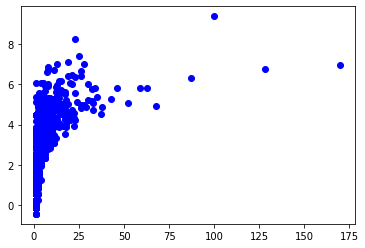

In [199]:
plt.plot(occurences, np.log(amount), 'o', color='blue')